In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy.signal import butter, freqz, lfilter, spectrogram

In [4]:
# Load in file to pandas dataframe
df = pd.read_table(
    "C:/Users/macka/Google Drive/Level-4-Project/data/raw/Dataset_97.dat",
    sep="\n",
    header=None)

In [5]:
# Switches out i for j to ensure python compatibility
def convert_to_complex(complex_string):
    return complex(complex_string[0].replace('i', 'j'))

In [6]:
# Grab RADAR settings from top of file
center_frequency = float(df.iloc[0])
sweep_time = float(df.iloc[1])/1000  # convert to seconds
number_of_time_samples = float(df.iloc[2])
bandwidth = float(df.iloc[3])
sampling_frequency = number_of_time_samples/sweep_time
record_length = 60
number_of_chirps = record_length/sweep_time

In [7]:
# Put data values into an array
data = df.iloc[4:]
data = data.apply(convert_to_complex, axis=1)
data = data.values

In [9]:
# Reshape into chirps over time
data_time = np.reshape(data, (int(number_of_chirps),int(number_of_time_samples)))
data_time = np.rot90(data_time, k=3)

In [10]:
# plt.imshow(abs(data_time),cmap='jet', aspect="auto")

In [11]:
win = np.ones((int(number_of_time_samples), data_time.shape[1]))

In [12]:
# Apply fast fourier transform
fft_applied = np.fft.fft((data_time * win), axis=0)

In [13]:
# plt.imshow(20*(np.log10(abs(fft_applied))),cmap='jet', aspect="auto")

In [14]:
# shift fft
fft_shifted = np.fft.fftshift(fft_applied, axes=(0,))

In [15]:
# plt.imshow(20*(np.log10(abs(fft_shifted))),cmap='jet', aspect="auto")

In [16]:
data_range = fft_shifted[int(number_of_time_samples/2):int(number_of_time_samples), :] # take top half

In [17]:
# plt.imshow(20*(np.log10(abs(data_range))),cmap='jet', aspect="auto")

In [18]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    else:
        return int(np.floor(x))

In [19]:
# IIR Notch filter
x = data_range.shape[1]
ns = nearest_odd_number(x) - 1

In [20]:
data_range_MTI = np.zeros((data_range.shape[0], ns), dtype=np.complex128)

In [21]:
(b, a) = butter(4, 0.01, btype="high") # made a filter remove DC component and very low frequency components

In [22]:
(f1, h) = freqz(b, a, ns)

In [23]:
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns], axis=0)

In [24]:
# plt.imshow(20*(np.log10(abs(data_range_MTI))),cmap='jet', aspect="auto")

In [25]:
freq = np.arange(0, ns-1)
freq = freq * sampling_frequency/(2*ns)

In [26]:
range_axis = (freq * 3e8*sweep_time)/(2*bandwidth)

In [27]:
print(data_range_MTI.shape)

(64, 60000)


In [28]:
data_range_MTI = data_range_MTI[1:, :]
data_range = data_range[1:, :]

In [29]:
print(data_range_MTI.shape)

(63, 60000)


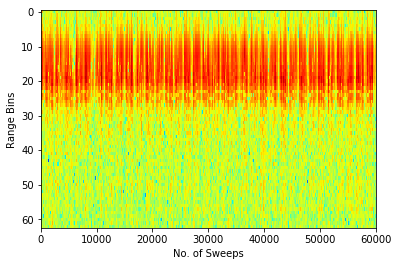

In [30]:
plt.xlabel("No. of Sweeps")
plt.ylabel("Range Bins")
plt.imshow(20 * np.log10(abs(data_range_MTI)),cmap='jet', aspect="auto")

In [31]:
bin_indl = 5
bin_indu = 25
prf = 1/sweep_time
time_window_length = 200
overlap_factor = 0.95
overlap_length = np.round(time_window_length * overlap_factor)
pad_factor = 4
fft_points = pad_factor * time_window_length
doppler_bin = prf / fft_points
doppler_axis = np.arange(-prf / 2, prf / 2 - doppler_bin + 1, doppler_bin)
whole_duration = data_range_MTI.shape[1] / prf
num_segments = np.floor((data_range_MTI.shape[1] - time_window_length) /
    (np.floor(time_window_length * (1 - overlap_factor))))

In [32]:
data_spec_MTI2=0
for rbin in range(bin_indl-1, bin_indu):    
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(time_window_length),
                            noverlap=overlap_length,
                            NFFT=time_window_length, 
                            mode='complex',
                            pad_to=fft_points )
    
    data_MTI_temp = np.fft.fftshift(s, 1)
    data_spec_MTI2=data_spec_MTI2+abs(data_MTI_temp);                                


In [33]:
time_axis = np.linspace(0, whole_duration, data_spec_MTI2.shape[1])

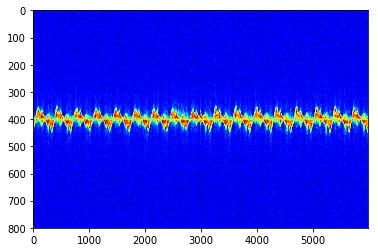

In [34]:
plt.imshow(20 * np.log10(abs(data_spec_MTI2)),cmap='jet', aspect="auto")

Text(0, 0.5, 'Doppler [Hz]')

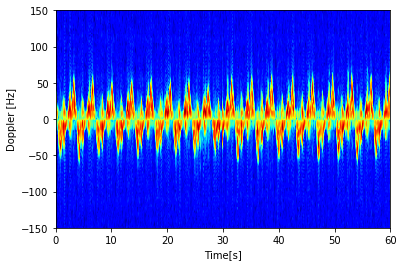

In [35]:
plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.abs(data_spec_MTI2)),cmap='jet')
plt.ylim([-150, 150])
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")

In [36]:
import time

In [37]:
print(data_spec_MTI2.shape)

(800, 5981)


In [38]:
from matplotlib import colors
image_width = 150
image_height = 150
minimum_value = 35
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)


In [40]:
    window_size = 300  # 3 seconds
    iterations = data_spec_MTI2.shape[1] - window_size
    step_size = 10  # 0.1 seconds
    for i in range(0, iterations, step_size):
        start_time = time.time()
        center = int(data_spec_MTI2.shape[0]/2)
        data_spec_small = data_spec_MTI2[(center-150):(center+150), i:(i + window_size)]
        w = 150
        h = 150
    
        fig = plt.figure(frameon=False)
        fig.set_size_inches(w,h)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(20 * np.log10(abs(data_spec_small)), cmap='jet', norm=norm, aspect="auto")
        fig.savefig("C:/Users/macka/Desktop/temp/" + str(i) + ".png", dpi=1)
        break
        time_for_row = (time.time() - start_time)/60
        print("\n--- %s minutes ---" % (time_for_row))
        